In [ ]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [ ]:
import os

# os.environ["CUDA_VISIBLE_DEVICES"]="-1" 
import tensorflow as tf
import numpy as np

# Set the seed for random operations. 
# This let our experiments to be reproducible. 
SEED = 1234
tf.random.set_seed(SEED)

In [ ]:
cwd = os.getcwd()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#Remember to remove last elements of training.txt

In [ ]:
!unzip /content/drive/MyDrive/image-segmentation/dataset/BPRW.zip

Archive:  /content/drive/MyDrive/image-segmentation/dataset/BPRW.zip
   creating: BPRW/
  inflating: BPRW/.DS_Store          
  inflating: __MACOSX/BPRW/._.DS_Store  
   creating: BPRW/Training/
   creating: BPRW/Test_Dev/
  inflating: BPRW/Training/.DS_Store  
  inflating: __MACOSX/BPRW/Training/._.DS_Store  
   creating: BPRW/Training/Images/
   creating: BPRW/Training/Masks/
  inflating: BPRW/Test_Dev/.DS_Store  
  inflating: __MACOSX/BPRW/Test_Dev/._.DS_Store  
   creating: BPRW/Test_Dev/Roseau/
   creating: BPRW/Test_Dev/Bipbip/
   creating: BPRW/Test_Dev/Pead/
   creating: BPRW/Test_Dev/Weedelec/
  inflating: BPRW/Training/Images/Roseau_haricot_0082_false.png  
  inflating: BPRW/Training/Images/Pead_mais_00801_i900.jpg  
  inflating: BPRW/Training/Images/Weedelec_haricot_2019-09-25T114639-68.jpg  
  inflating: BPRW/Training/Images/Roseau_haricot_0388_false.png  
  inflating: BPRW/Training/Images/Bipbip_haricot_im_07131.jpg  
  inflating: BPRW/Training/Images/Pead_mais_00599_i900.

In [ ]:
!rm -r /content/__MACOSX
#!rm -r /content/BPRW
#!rm -r /content/Development_Dataset_Sub

In [ ]:
def filter(file_list, Mais=True, Haricot=True, Bipbip=True, Pead=True, Roseau=True, Weedelec=True):
  file_list = [k for k in file_list if not ('.' in k)] # remove hidden files
  # WARNING if any files has '.' in the name it will be removed but this is not
  #         the case for our dataset
  if not Mais:
    file_list = [k for k in file_list if not ('Mais' in k)]
  if not Haricot:
    file_list = [k for k in file_list if not ('Haricot' in k)]
  if not Bipbip:
    file_list = [k for k in file_list if not ('Bipbip' in k)]
  if not Pead:
    file_list = [k for k in file_list if not ('Pead' in k)]
  if not Roseau:
    file_list = [k for k in file_list if not ('Roseau' in k)]
  if not Weedelec:
    file_list = [k for k in file_list if not ('Weedelec' in k)]
  
  return file_list

## Create 224 x 224 tiles of images and masks 



In [ ]:
#!pip install image_slicer

In [ ]:
# create split files
import re
import math
import random

os.chdir('/content/BPRW/Training')
#os.chdir(os.path.join(os.getcwd(), 'Haricot')) # change to change dataset
cwd = os.getcwd()
dir = os.path.join(cwd, 'Images')
file_list = os.listdir(dir)

for i, file_name in enumerate(file_list):
  file_list[i] = re.sub('.jpg', '', file_name)

file_list = filter(file_list, Mais=True, Haricot=True, Bipbip=False, Pead=True, Roseau=False, Weedelec=False)

random.seed(SEED)
random.shuffle(file_list)

valid_cut = .2
valid_files = file_list[math.floor(len(file_list)*(1-valid_cut)):len(file_list)]
train_files = file_list[0:math.floor(len(file_list)*(1-valid_cut))]

split_dir = os.path.join(cwd, 'Splits')
if not os.path.exists(split_dir):
  os.makedirs(split_dir)

with open("Splits/training.txt","w+") as traintxt:
  traintxt.writelines(["%s\n" % el  for el in train_files])

with open("Splits/validation.txt","w+") as validtxt:
  validtxt.writelines(["%s\n" % el  for el in valid_files])

os.chdir('/content')
cwd = os.getcwd()

In [ ]:

subset_file = os.path.join("/content/BPRW/Training/", 'Splits', 'training.txt')

with open(subset_file, 'r') as f:
  lines = f.readlines()
    
subset_filenames = []

for line in lines:
  subset_filenames.append(line.strip())



In [ ]:
from contextlib import contextmanager
import sys, os

@contextmanager
def suppress_stdout():
    with open(os.devnull, "w") as devnull:
        old_stdout = sys.stdout
        sys.stdout = devnull
        try:  
            yield
        finally:
            sys.stdout = old_stdout

In [ ]:
import cv2
import math

#image_slicer.slice("/content/Development_Dataset_Sub/Bipbip/Haricot/Images/img/Bipbip_haricot_im_05231.jpg", 4)

new_filenames = []


for image in subset_filenames:

  with suppress_stdout():
    img = cv2.imread("/content/BPRW/Training/Images/"+image+".jpg") 
    mask = cv2.imread("/content/BPRW/Training/Masks/"+image+".png")

  img_shape = img.shape
  mask_shape = mask.shape
  tile_size = (224, 224)
  offset = (224, 224)
  #image
  for i in range(int(math.ceil(img_shape[0]/(offset[1] * 1.0)))):
      for j in range(int(math.ceil(img_shape[1]/(offset[0] * 1.0)))):
          cropped_img = img[offset[1]*i:min(offset[1]*i+tile_size[1], img_shape[0]), offset[0]*j:min(offset[0]*j+tile_size[0], img_shape[1])]
          new_filenames.append("splitted_"+image+"_"+ str(i) + "_" + str(j))
          # Debugging the tiles
          with suppress_stdout():
            cv2.imwrite("/content/BPRW/Training/Images/splitted_"+image+"_"+ str(i) + "_" + str(j) + ".jpg", cropped_img)
          
          
  #mask
  for i in range(int(math.ceil(mask_shape[0]/(offset[1] * 1.0)))):
      for j in range(int(math.ceil(mask_shape[1]/(offset[0] * 1.0)))):
          cropped_img = mask[offset[1]*i:min(offset[1]*i+tile_size[1], mask_shape[0]), offset[0]*j:min(offset[0]*j+tile_size[0], mask_shape[1])]
          # Debugging the tiles
          with suppress_stdout():
            cv2.imwrite("/content/BPRW/Training/Masks/splitted_"+image+"_"+ str(i) + "_" + str(j) + ".png", cropped_img)
              

  os.remove("/content/BPRW/Training/Images/"+image+".jpg")
  os.remove("/content/BPRW/Training/Masks/"+image+".png")
             

#new_filenames 

with open(subset_file, 'w') as f:
  for item in new_filenames:
      f.write("%s\n" % item.split('.')[0])


# Example: Image Segmentation
## Build segmentation

In [ ]:
# ImageDataGenerator
# ------------------

from tensorflow.keras.preprocessing.image import ImageDataGenerator

apply_data_augmentation = True

# Create training ImageDataGenerator object
# We need two different generators for images and corresponding masks
if apply_data_augmentation:
    img_data_gen = ImageDataGenerator(rotation_range=10,
                                      width_shift_range=10,
                                      height_shift_range=10,
                                      zoom_range=0.3,
                                      horizontal_flip=True,
                                      vertical_flip=True,
                                      fill_mode='reflect')
    mask_data_gen = ImageDataGenerator(rotation_range=10,
                                       width_shift_range=10,
                                       height_shift_range=10,
                                       zoom_range=0.3,
                                       horizontal_flip=True,
                                       vertical_flip=True,
                                       fill_mode='reflect')

In [ ]:
from PIL import Image

img_h = 224
img_w = 224

#img_h = 384
#img_w = 512

mask_h = int(2464)
mask_w = int(3280)

class CustomDataset(tf.keras.utils.Sequence):

  """
    CustomDataset inheriting from tf.keras.utils.Sequence.

    3 main methods:
      - __init__: save dataset params like directory, filenames..
      - __len__: return the total number of samples in the dataset
      - __getitem__: return a sample from the dataset

    Note: 
      - the custom dataset return a single sample from the dataset. Then, we use 
        a tf.data.Dataset object to group samples into batches.
      - in this case we have a different structure of the dataset in memory. 
        We have all the images in the same folder and the training and validation splits
        are defined in text files.

  """

  def __init__(
    self, dataset_dir,
    which_subset,
    img_generator=None,
    mask_generator=None, 
    preprocessing_function=None,
     out_shape=[224,224] 
  ):
    if which_subset == 'training':
      subset_file = os.path.join(dataset_dir, 'Splits', 'training.txt')
    elif which_subset == 'validation':
      subset_file = os.path.join(dataset_dir, 'Splits', 'validation.txt')
    
    with open(subset_file, 'r') as f:
      lines = f.readlines()
    
    subset_filenames = []
    for line in lines:
      subset_filenames.append(line.strip()) 

    self.which_subset = which_subset
    self.dataset_dir = dataset_dir
    self.subset_filenames = subset_filenames
    self.img_generator = img_generator
    self.mask_generator = mask_generator
    self.preprocessing_function = preprocessing_function
    self.out_shape = out_shape

  def __len__(self):
    return len(self.subset_filenames)

  def __getitem__(self, index):
    # Read Image
    curr_filename = self.subset_filenames[index]
    img = Image.open(os.path.join(self.dataset_dir, 'Images/', curr_filename + '.jpg'))
    mask = Image.open(os.path.join(self.dataset_dir, 'Masks/', curr_filename + '.png'))


    # Resize image and mask
    if self.which_subset == 'training':
      img = img.resize(self.out_shape)
      mask = mask.resize(self.out_shape, resample=Image.NEAREST)

    if self.which_subset == 'validation':
      img = img.resize((mask_w, mask_h))
      mask = mask.resize((mask_w, mask_h), resample=Image.NEAREST)
    #else:
     # img = img.resize((1024,768))  
     # mask = img.resize((1024,768))  
    
    img_arr = np.array(img)
    mask_arr = np.array(mask)

    new_mask_arr = np.zeros(mask_arr.shape[:2], dtype=mask_arr.dtype)

    # Use RGB dictionary in 'RGBtoTarget.txt' to convert RGB to target
    new_mask_arr[np.where(np.all(mask_arr == [0, 0, 0], axis=-1))] = 0
    new_mask_arr[np.where(np.all(mask_arr == [254, 124, 18], axis=-1))] = 0 #previous first element 216
    new_mask_arr[np.where(np.all(mask_arr == [255, 255, 255], axis=-1))] = 1
    new_mask_arr[np.where(np.all(mask_arr == [216, 67, 82], axis=-1))] = 2

    mask_arr = new_mask_arr

    # in this dataset 255 mask label is assigned to an additional class, which corresponds 
    # to the contours of the objects. We remove it for simplicity.
    mask_arr[mask_arr == 255] = 0  

    mask_arr = np.expand_dims(mask_arr, -1)

    if self.which_subset == 'training':
      if self.img_generator is not None and self.mask_generator is not None:
        # Perform data augmentation
        # We can get a random transformation from the ImageDataGenerator using get_random_transform
        # and we can apply it to the image using apply_transform
        img_t = self.img_generator.get_random_transform(img_arr.shape, seed=SEED)
        mask_t = self.mask_generator.get_random_transform(mask_arr.shape, seed=SEED)
        img_arr = self.img_generator.apply_transform(img_arr, img_t)
        # ImageDataGenerator use bilinear interpolation for augmenting the images.
        # Thus, when applied to the masks it will output 'interpolated classes', which
        # is an unwanted behaviour. As a trick, we can transform each class mask 
        # separately and then we can cast to integer values (as in the binary segmentation notebook).
        # Finally, we merge the augmented binary masks to obtain the final segmentation mask.
        out_mask = np.zeros_like(mask_arr)
        for c in np.unique(mask_arr):
          if c > 0:
            curr_class_arr = np.float32(mask_arr == c)
            curr_class_arr = self.mask_generator.apply_transform(curr_class_arr, mask_t)
            # from [0, 1] to {0, 1}
            curr_class_arr = np.uint8(curr_class_arr)
            # recover original class
            curr_class_arr = curr_class_arr * c 
            out_mask += curr_class_arr
    else:
      out_mask = mask_arr
    
    if self.preprocessing_function is not None:
        img_arr = self.preprocessing_function(img_arr)

    return img_arr, np.float32(out_mask)

In [ ]:
os.path.join(cwd, "Development_Dataset_Sub")

In [ ]:
from tensorflow.keras.applications.vgg16 import preprocess_input 



dataset = CustomDataset("/content/BPRW/Training", 'training', 
                        img_generator=img_data_gen, mask_generator=mask_data_gen,
                        preprocessing_function=None) #preprocess_input
dataset_valid = CustomDataset('/content/BPRW/Training', 'validation', 
                              preprocessing_function=None)


In [ ]:

train_dataset = tf.data.Dataset.from_generator(lambda: dataset,
                                               output_types=(tf.float32, tf.float32),
                                               output_shapes=([img_h, img_w, 3], [img_h, img_w, 1]))

train_dataset = train_dataset.batch(32)

train_dataset = train_dataset.repeat()

valid_dataset = tf.data.Dataset.from_generator(lambda: dataset_valid,
                                               output_types=(tf.float32, tf.float32),
                                               output_shapes=([int(mask_h), int(mask_w), 3], [int(mask_h), int(mask_w), 1]))
valid_dataset = valid_dataset.batch(1)

valid_dataset = valid_dataset.repeat()

In [ ]:
!ls /content/VOCDataset

In [ ]:
# Let's test data generator
# -------------------------
import time
from matplotlib import cm
import matplotlib.pyplot as plt

%matplotlib inline


# Assign a color to each class
colors_dict = {}
colors_dict[2] = [255, 0,0]
colors_dict[1] = [255, 255, 255]  # foreground
colors_dict[0] = [0, 0, 0]  # background
iterator = iter(valid_dataset)


TensorShape([2464, 3280, 3])

[0. 1. 2.]


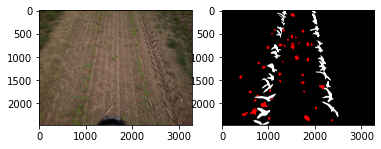

In [ ]:
fig, ax = plt.subplots(1, 2)



augmented_img, target = next(iterator)
augmented_img = augmented_img[0]   # First element
augmented_img = augmented_img  # denormalize

augmented_img.shape

target = np.array(target[0, ..., 0])   # First element (squeezing channel dimension)

print(np.unique(target))

target_img = np.zeros([target.shape[0], target.shape[1], 3])

target_img[np.where(target == 0)] = colors_dict[0]
target_img[np.where(target == 1)] = colors_dict[1]
target_img[np.where(target == 2)] = colors_dict[2]

ax[0].imshow(np.uint8(augmented_img))
ax[1].imshow(np.uint8(target_img))

plt.show()

## Convolutional Neural Network (CNN)
### Encoder-Decoder

In [ ]:
# Create Model
# ------------

def create_model(depth, start_f, num_classes, dynamic_input_shape):

    model = tf.keras.Sequential()

    skip = {}
    
    # Encoder
    # -------
    for i in range(depth):
        
        if i == 0:
            if dynamic_input_shape:
                input_shape = [None, None, 3]
            else:
                input_shape = [img_h, img_w, 3]
        else:
            input_shape=[None]
        
        model.add(tf.keras.layers.Conv2D(filters=start_f, 
                                         kernel_size=(3, 3),
                                         strides=(1, 1),
                                         padding='same',
                                         input_shape=input_shape))
        model.add(tf.keras.layers.ReLU())
        skip[i] = tf.keras.layers.Conv2D(filters=start_f, 
                                         kernel_size=(3, 3),
                                         strides=(1, 1),
                                         padding='same',
                                         input_shape=input_shape)
        model.add(skip[i])
        model.add(tf.keras.layers.ReLU())
        model.add(tf.keras.layers.MaxPool2D(pool_size=(2, 2)))

        start_f *= 2

    # Bottleneck
    model.add(tf.keras.layers.Conv2D(filters=start_f, kernel_size=(3, 3), strides=(1, 1), padding='same'))
    model.add(tf.keras.layers.ReLU())

    start_f *= 2

    model.add(tf.keras.layers.Conv2D(filters=start_f, kernel_size=(3, 3), strides=(1, 1), padding='same'))
    model.add(tf.keras.layers.ReLU())

    model.add(tf.keras.layers.Conv2D(filters=start_f, kernel_size=(3, 3), strides=(1, 1), padding='same'))
    model.add(tf.keras.layers.ReLU())
    
    start_f = start_f // 2

  

    for i in range(depth):
          model.add(tf.keras.layers.UpSampling2D(2, interpolation='bilinear'))

          model.add(tf.keras.layers.Conv2D(filters=start_f,
                                                kernel_size=(3, 3),
                                                strides=(1, 1),
                                                padding='same'))
          model.add(tf.keras.layers.ReLU())
          model.add(tf.keras.layers.Conv2D(filters=start_f,
                                                kernel_size=(3, 3),
                                                strides=(1, 1),
                                                padding='same'))
          model.add(tf.keras.layers.ReLU())

          start_f = start_f // 2


    # Prediction Layer
    # ----------------
    model.add(tf.keras.layers.Conv2D(filters=num_classes,
                                     kernel_size=(1, 1),
                                     strides=(1, 1),
                                     padding='same',
                                     activation='sigmoid'))
    
    return model

In [ ]:
model = create_model(depth = 5, start_f = 12, num_classes = 3, dynamic_input_shape = True)
#model = create_model_skip(depth , start_f, num_classes, dynamic_input_shape)
# Visualize created model as a table
model.summary()

# Visualize initialized weights
# model.weights

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_120 (Conv2D)          (None, None, None, 12)    336       
_________________________________________________________________
re_lu_115 (ReLU)             (None, None, None, 12)    0         
_________________________________________________________________
conv2d_121 (Conv2D)          (None, None, None, 12)    1308      
_________________________________________________________________
re_lu_116 (ReLU)             (None, None, None, 12)    0         
_________________________________________________________________
max_pooling2d_25 (MaxPooling (None, None, None, 12)    0         
_________________________________________________________________
conv2d_122 (Conv2D)          (None, None, None, 24)    2616      
_________________________________________________________________
re_lu_117 (ReLU)             (None, None, None, 24)   

## Prepare the model for training

In [ ]:
# Optimization params
# -------------------

# Loss
# Sparse Categorical Crossentropy to use integers (mask) instead of one-hot encoded labels
loss = tf.keras.losses.SparseCategoricalCrossentropy() 
# learning rate
lr = 1e-4
optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
# -------------------

# Here we define the intersection over union for each class in the batch.
# Then we compute the final iou as the mean over classes
def meanIoU(y_true, y_pred):
    # get predicted class from softmax
    y_pred = tf.expand_dims(tf.argmax(y_pred, -1), -1)

    per_class_iou = []

    for i in range(1,2): # exclude the background class 0
      # Get prediction and target related to only a single class (i)
      class_pred = tf.cast(tf.where(y_pred == i, 1, 0), tf.float32)
      class_true = tf.cast(tf.where(y_true == i, 1, 0), tf.float32)
      intersection = tf.reduce_sum(class_true * class_pred)
      union = tf.reduce_sum(class_true) + tf.reduce_sum(class_pred) - intersection
    
      iou = (intersection + 1e-7) / (union + 1e-7)
      per_class_iou.append(iou)

    return tf.reduce_mean(per_class_iou)

# Validation metrics
# ------------------
metrics = ['accuracy', meanIoU]
# ------------------

# Compile Model
model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

## Training with callbacks

In [ ]:
model.evaluate(valid_dataset,batch_size = 1, steps = 1)

ValueError: ignored

In [ ]:
import os
from datetime import datetime

cwd = os.getcwd()

exps_dir = os.path.join(cwd, 'drive/My Drive/Keras4/', 'Crop_Experiments_No_Skip_CNN')
if not os.path.exists(exps_dir):
    os.makedirs(exps_dir)

now = datetime.now().strftime('%b%d_%H-%M-%S')

model_name = 'CNN'

exp_dir = os.path.join(exps_dir, model_name + '_' + str(now))
if not os.path.exists(exp_dir):
    os.makedirs(exp_dir)
    
callbacks = []

# Model checkpoint
# ----------------
ckpt_dir = os.path.join(exp_dir, 'ckpts')
if not os.path.exists(ckpt_dir):
    os.makedirs(ckpt_dir)

ckpt_callback = tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(ckpt_dir, 'cp_{epoch:02d}.ckpt'), 
                                                   save_weights_only=True)  # False to save the model directly
callbacks.append(ckpt_callback)

# Visualize Learning on Tensorboard
# ---------------------------------
tb_dir = os.path.join(exp_dir, 'tb_logs')
if not os.path.exists(tb_dir):
    os.makedirs(tb_dir)
    
# By default shows losses and metrics for both training and validation
tb_callback = tf.keras.callbacks.TensorBoard(log_dir=tb_dir,
                                             profile_batch=0,
                                             histogram_freq=0)  # if 1 shows weights histograms
callbacks.append(tb_callback)

# Early Stopping
# --------------
early_stop = True
if early_stop:
    es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights = True)
    callbacks.append(es_callback)


model.fit(x=train_dataset,
          epochs=100,  #### set repeat in training dataset
          steps_per_epoch=len(dataset)/32, #divided by batch size
          validation_data=valid_dataset,
          validation_steps=len(dataset_valid)/1, 
          callbacks=callbacks)

# How to visualize Tensorboard

# 1. tensorboard --logdir EXPERIMENTS_DIR --port PORT     <- from terminal
# 2. localhost:PORT   <- in your browser

Epoch 1/100
1728/1728 [==============================] - 1276s 739ms/step - loss: 0.0771 - accuracy: 0.9703 - meanIoU: 0.6208 - val_loss: 0.0691 - val_accuracy: 0.9729 - val_meanIoU: 0.7283
Epoch 2/100
1728/1728 [==============================] - 1217s 705ms/step - loss: 0.0664 - accuracy: 0.9750 - meanIoU: 0.6613 - val_loss: 0.0683 - val_accuracy: 0.9730 - val_meanIoU: 0.7370
Epoch 3/100
 367/1728 [=====>........................] - ETA: 15:05 - loss: 0.0613 - accuracy: 0.9772 - meanIoU: 0.6748

KeyboardInterrupt: ignored

## Test model

## Compute prediction

In [ ]:
model.load_weights('/content/drive/My Drive/Keras4/Crop_Experiments_No_Skip_CNN/CNN_Dec14_13-01-52/ckpts/cp_02.ckpt')

In [ ]:
import time
import matplotlib.pyplot as plt

from PIL import Image

%matplotlib inline

iterator = iter(valid_dataset)

TensorShape([1536, 2048, 3])

TensorShape([1536, 2048])

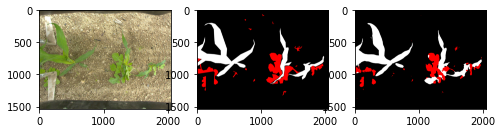

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(8, 8))
fig.show()
#iterator = iter(valid_dataset)
image, target = next(iterator)

image = image[0]
image.shape
target = target[0, ..., 0]

out_sigmoid = model.predict(x=tf.expand_dims(image, 0))

# Get predicted class as the index corresponding to the maximum value in the vector probability
# predicted_class = tf.cast(out_sigmoid > score_th, tf.int32)
# predicted_class = predicted_class[0, ..., 0]
predicted_class = tf.argmax(out_sigmoid, -1)

#out_sigmoid.shape

predicted_class = predicted_class[0, ...]
predicted_class.shape


# Assign colors (just for visualization)
target_img = np.zeros([target.shape[0], target.shape[1], 3])
prediction_img = np.zeros([target.shape[0], target.shape[1], 3])

target_img[np.where(target == 0)] = colors_dict[0]
target_img[np.where(target == 1)] = colors_dict[1]
target_img[np.where(target == 2)] = colors_dict[2]

prediction_img[np.where(predicted_class == 0)] = colors_dict[0]
prediction_img[np.where(predicted_class == 1)] = colors_dict[1]
prediction_img[np.where(predicted_class == 2)] = colors_dict[2]


ax[0].imshow(np.uint8(image))
ax[1].imshow(np.uint8(target_img))
ax[2].imshow(np.uint8(prediction_img))

img = Image.fromarray(np.uint8(prediction_img)).resize((mask_w,mask_h), Image.NEAREST)



fig.canvas.draw()
time.sleep(1)

In [ ]:
!unzip /content/drive/MyDrive/image-segmentation/dataset/Test_Dev.zip

In [ ]:
import os
import json
import numpy as np
from PIL import Image


def rle_encode(img):
    '''
    img: numpy array, 1 - foreground, 0 - background
    Returns run length as string formatted
    '''
    pixels = img.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    
    return ' '.join(str(x) for x in runs)

In [ ]:
data_folders = next(os.walk("/content/BPRW/Test_Dev/"))[1]
data_folders
for ds in data_folders:
  subset_folders = next(os.walk("/content/BPRW/Test_Dev/"+ds))[1]
  subset_folders
  for sb in subset_folders:
    test_filenames = next(os.walk("/content/BPRW/Test_Dev/"+ds+"/"+sb+"/Images"))[2]
    #test_filenames
    #for name in test_filenames:
    #  name
 

['Bipbip', 'Weedelec', 'Roseau', 'Pead']

['Mais', 'Haricot']

['Mais', 'Haricot']

['Mais', 'Haricot']

['Mais', 'Haricot']

In [ ]:

    # The submission file will be a zip file containing the a
    # submission.json file.

    # It must have the following structure:

    # - image name (without any extension, e.g., png, jpg, etc.)
    #   - shape: shape of the original image as list [Height, Width]
    #   - team: team of the original image. One in {'Bipbip', 'Pead', 'Roseau', 'Weedelec'}
    #   - crop: crop of the original image. One in {'Haricot', 'Mais'}
    #   - segmentation: prediction (as a dict)
    #     - crop: RLE encoded crop segmentation (no weed)
    #     - weed: RLE encoded weed segmentation (no crop)

    # Please refer to the folder structure of the given dataset to fill
    # the team and crop keys.

    # EXAMPLE:

    # Suppose that the numpy array generated with the
    # 'read_mask_example.py' script is the output of your segmentation model.
    # In addition, suppose that the team and crop of the segmented image
    # are 'Bipbip' and 'Haricot', respectively.
    # Then, in the following an example of submission file.
  
    #loop over test images
data_folders = next(os.walk("/content/BPRW/Test_Dev/"))[1]

submission_dict = {}

for ds in data_folders:
  subset_folders = next(os.walk("/content/BPRW/Test_Dev/"+ds))[1]
  for sb in subset_folders:

    test_filenames = next(os.walk("/content/BPRW/Test_Dev/"+ds+"/"+sb+"/Images"))[2]
    #test_filenames[:1]

    for image_name in test_filenames:

      img_name = image_name.split(".")[0]

      # load mask <- HERE you should have your segmentation model instead
      if (True):
        image = Image.open("/content/BPRW/Test_Dev/"+ds+"/"+sb+"/Images/"+image_name).convert('RGB')
        width, height = image.size
        #image.size
        #resize image before computing prediction
        image = image.resize((int(width/2), int(height/2)))
       # image.size
        #image

        image_array = tf.cast(tf.expand_dims(np.array(image), 0), tf.float32) #substitute pre with image
        
       # image_array
        #image_array = preprocess_input(image_array)
        #compute mask prediction
        out_sigmoid = model.predict(x = image_array)

        predicted_class = tf.argmax(out_sigmoid, -1)
      

        predicted_class = predicted_class[0, ...]
        prediction_img = np.zeros([int(height/2),int(width/2), 3])
        

        

        prediction_img[np.where(predicted_class == 0)] = colors_dict[0]
        prediction_img[np.where(predicted_class == 1)] = colors_dict[1]
        prediction_img[np.where(predicted_class == 2)] = colors_dict[2]

        
        img = Image.fromarray(np.uint8(prediction_img)).resize((width, height), Image.NEAREST)
        #img
        mask_arr = np.array(img)

        new_mask_arr = np.zeros(mask_arr.shape[:2], dtype=mask_arr.dtype)

          # Use RGB dictionary in 'RGBtoTarget.txt' to convert RGB to target
        new_mask_arr[np.where(np.all(mask_arr == colors_dict[0], axis=-1))] = 0
        new_mask_arr[np.where(np.all(mask_arr == colors_dict[1], axis=-1))] = 1
        new_mask_arr[np.where(np.all(mask_arr == colors_dict[2], axis=-1))] = 2
       # predicted_class
        mask_arr = new_mask_arr
      else:
        mask_arr = np.zeros([mask_w, mask_h, 3]) 
      #image_array
      #mask_arr
      

      submission_dict[img_name] = {}
      submission_dict[img_name]['shape'] = mask_arr.shape
      submission_dict[img_name]['team'] = ds
      submission_dict[img_name]['crop'] = sb
      submission_dict[img_name]['segmentation'] = {}

          # RLE encoding
          # crop
      rle_encoded_crop = rle_encode(mask_arr == 1)
          # weed
      rle_encoded_weed = rle_encode(mask_arr == 2)

      submission_dict[img_name]['segmentation']['crop'] = rle_encoded_crop
      submission_dict[img_name]['segmentation']['weed'] = rle_encoded_weed

#submission_dict
# Please notice that in this example we have a single prediction.
# For the competition you have to provide segmentation for each of
# the test images.

# Finally, save the results into the submission.json file
with open('/content/submission.json', 'w') as f:
    json.dump(submission_dict, f)
